# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import keras
import keras.layers as L
import keras.models as M
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from path import Path
from keras.utils import Sequence

# Loading CSV

In [ ]:
train=pd.read_csv('../input/handwriting-recognition/written_name_train_v2.csv')
validation=pd.read_csv('../input/handwriting-recognition/written_name_validation_v2.csv')

# EDA

In [ ]:
train.shape, validation.shape

((330961, 2), (41370, 2))

In [ ]:
train.isnull().sum()

FILENAME      0
IDENTITY    565
dtype: int64

In [ ]:
validation.isnull().sum()

FILENAME    0
IDENTITY    2
dtype: int64

In [ ]:
train.dropna(inplace=True)
validation.dropna(inplace=True)

In [ ]:
train.shape

(330396, 2)

In [ ]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
train.describe()

,FILENAME,IDENTITY
count,330396,330396
unique,330396,100539
top,TRAIN_159843.jpg,THOMAS
freq,1,1825


In [ ]:
train[train['IDENTITY']=='THOMAS']

,FILENAME,IDENTITY
26,TRAIN_00027.jpg,THOMAS
84,TRAIN_00085.jpg,THOMAS
166,TRAIN_00167.jpg,THOMAS
250,TRAIN_00251.jpg,THOMAS
898,TRAIN_00899.jpg,THOMAS
...,...,...
330252,TRAIN_330253.jpg,THOMAS
330456,TRAIN_330457.jpg,THOMAS
330744,TRAIN_330745.jpg,THOMAS
330902,TRAIN_330903.jpg,THOMAS


In [ ]:
train[train['IDENTITY'].duplicated()]

,FILENAME,IDENTITY
37,TRAIN_00038.jpg,PAULINE
54,TRAIN_00055.jpg,MATHEO
75,TRAIN_00076.jpg,ELISA
77,TRAIN_00078.jpg,MAEVA
84,TRAIN_00085.jpg,THOMAS
...,...,...
330955,TRAIN_330956.jpg,CORENTIN
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330959,TRAIN_330960.jpg,MOURAD


In [ ]:
train[train['IDENTITY']=='PAULINE']

,FILENAME,IDENTITY
16,TRAIN_00017.jpg,PAULINE
37,TRAIN_00038.jpg,PAULINE
604,TRAIN_00605.jpg,PAULINE
613,TRAIN_00614.jpg,PAULINE
776,TRAIN_00777.jpg,PAULINE
...,...,...
329067,TRAIN_329068.jpg,PAULINE
329328,TRAIN_329329.jpg,PAULINE
329641,TRAIN_329642.jpg,PAULINE
330240,TRAIN_330241.jpg,PAULINE


# Preprocessing

In [ ]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]

,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [ ]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)

In [ ]:
train.shape, validation.shape

((211448, 3), (414, 2))

# Collencting all Characters present in dataset

In [ ]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)

In [ ]:
characters

[' ',
 "'",
 '-',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '`']

In [ ]:
len(characters)

30

# Creating dictionaries

In [ ]:
# 2 Dictionaries  :   Turn all ur characters to num and vice versa
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [ ]:
char_to_label

{' ': 0,
 "'": 1,
 '-': 2,
 'A': 3,
 'B': 4,
 'C': 5,
 'D': 6,
 'E': 7,
 'F': 8,
 'G': 9,
 'H': 10,
 'I': 11,
 'J': 12,
 'K': 13,
 'L': 14,
 'M': 15,
 'N': 16,
 'O': 17,
 'P': 18,
 'Q': 19,
 'R': 20,
 'S': 21,
 'T': 22,
 'U': 23,
 'V': 24,
 'W': 25,
 'X': 26,
 'Y': 27,
 'Z': 28,
 '`': 29}

In [ ]:
label_to_char

{0: ' ',
 1: "'",
 2: '-',
 3: 'A',
 4: 'B',
 5: 'C',
 6: 'D',
 7: 'E',
 8: 'F',
 9: 'G',
 10: 'H',
 11: 'I',
 12: 'J',
 13: 'K',
 14: 'L',
 15: 'M',
 16: 'N',
 17: 'O',
 18: 'P',
 19: 'Q',
 20: 'R',
 21: 'S',
 22: 'T',
 23: 'U',
 24: 'V',
 25: 'W',
 26: 'X',
 27: 'Y',
 28: 'Z',
 29: '`'}

# Define path of images

In [ ]:
path_train='../input/handwriting-recognition/train_v2/train'
path_validation='../input/handwriting-recognition/validation_v2/validation'

In [ ]:
path_train + '/' + train['FILENAME'][0]

'../input/handwriting-recognition/train_v2/train/TRAIN_00001.jpg'

## images sample

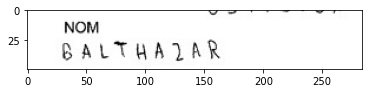

In [ ]:
show_img = cv2.imread(Path(path_train + '/' + train['FILENAME'][0]))
plt.imshow(show_img)

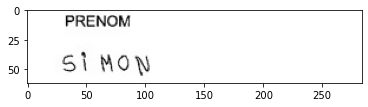

In [ ]:
show_img = cv2.imread(Path(path_train + '/' + train['FILENAME'][1]))
plt.imshow(show_img)

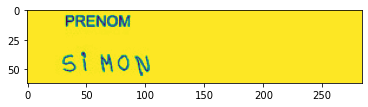

In [ ]:
show_img=cv2.cvtColor(show_img, cv2.COLOR_BGR2GRAY)
plt.imshow(show_img)

In [ ]:
show_img.shape

(62, 284)

In [ ]:
show_img=cv2.resize(show_img,(256,64))
print(show_img.shape)

(64, 256)


In [ ]:
show_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
show_img=(show_img/255).astype(np.float32)
show_img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

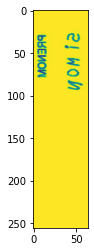

In [ ]:
show_img = show_img.T
plt.imshow(show_img)

In [ ]:
show_img=np.expand_dims(show_img,axis=-1)
show_img.shape

(256, 64, 1)

# Data generator

In [ ]:
# Data Generator
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.dataframe)//self.batch_size
    
    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text: 
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length
                
            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)
        

## Preprocess all images

In [ ]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)

Connectionist temporal classification (CTC) is a type of neural network output and associated scoring function, for training recurrent neural networks (RNNs) such as LSTM networks to tackle sequence problems where the timing is variable.

In [ ]:
# Making CTC Function
class CTCLayer(L.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

# Making model

In [ ]:
def make_model():
    inp=L.Input(shape=(256,64,1),dtype=np.float32,name='input_data')
    labels=L.Input(shape=[22],dtype=np.float32,name='input_label')
    input_length=L.Input(shape=[1],dtype=np.int64,name='input_length')
    label_length=L.Input(shape=[1],dtype=np.int64,name='label_length')
    x=L.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inp)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    x=L.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    new_shape=((256//4),(64//4)*128)
    x=L.Reshape(new_shape)(x)
    x=L.Dense(64,activation='relu')(x)
    x=L.Dropout(0.2)(x)
    x=L.Bidirectional(L.LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=L.Bidirectional(L.LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=L.Dense(len(characters)+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_length,label_length)
    model=M.Model([inp,labels,input_length,label_length],output)
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    model.compile(optimizer=sgd)
    return model

# model summary

In [ ]:
model=make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 64, 64)  640         input_data[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 32, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 32, 64)  0           max_pooling2d[0][0]              
______________________________________________________________________________________________

## Add early stopping

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    history = model.fit(train_generator,steps_per_epoch=1000,validation_data=validation_generator,
                        epochs=5)


Epoch 1/5
1000/1000 [==============================] - 858s 850ms/step - loss: 23.6168 - val_loss: 19.0940
Epoch 2/5
1000/1000 [==============================] - 525s 525ms/step - loss: 18.7743 - val_loss: 17.7790
Epoch 3/5
1000/1000 [==============================] - 415s 415ms/step - loss: 17.1417 - val_loss: 14.3807
Epoch 4/5
1000/1000 [==============================] - 371s 371ms/step - loss: 13.1428 - val_loss: 8.5301
Epoch 5/5
1000/1000 [==============================] - 340s 340ms/step - loss: 8.6503 - val_loss: 5.3629


## Train model

In [ ]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='Dense_output').output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 64, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 32, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 32, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 32, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 128)       0   

# Save weights

In [ ]:
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    prediction_model.save('prediction_model_ocr.h5')
    prediction_model=M.load_model('prediction_model_ocr.h5')

## decode the output of the network

In [ ]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

## Predicting on validation dataset

Ground truth: MICHELON 	 Predicted: NICHELON
Ground truth: CHAPUIS-REGNIER 	 Predicted: CHAPUIS REGNIEA
Ground truth: THIBAUT 	 Predicted: THCOAUY
Ground truth: FABIEN 	 Predicted: FAOIEN
Ground truth: LEGAL 	 Predicted: LEGRAL
Ground truth: VINCENT 	 Predicted: VINEENT
Ground truth: TIMOTHEE 	 Predicted: TIROTHEE
Ground truth: COUTURE 	 Predicted: LOUTURE
Ground truth: COEFFIER 	 Predicted: COCTEIER
Ground truth: ALIX 	 Predicted: ALIA
Ground truth: AMI SAADA 	 Predicted: MN  TAAOA
Ground truth: GEROOVILLE 	 Predicted: GEROOUILLE
Ground truth: ZOE 	 Predicted: JOE
Ground truth: CARDON 	 Predicted: CARDON
Ground truth: CECILE 	 Predicted: CECILE
Ground truth: THOMAS 	 Predicted: THOMAS
Ground truth: MARGOT 	 Predicted: MARGOT
Ground truth: ETIENNE 	 Predicted: EAIEANE
Ground truth: DAMIEN 	 Predicted: BAMIEN
Ground truth: BRIGANT 	 Predicted: BAIGANT
Ground truth: LILOU 	 Predicted: LILOU
Ground truth: CILOU 	 Predicted: LILOU
Ground truth: HUGO 	 Predicted: NUCA
Ground truth: SALOTTI 

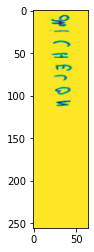

In [ ]:
for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    plt.imshow(X_data[0])
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Predicted Text: JULES


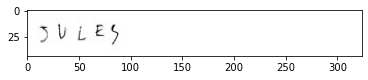

In [ ]:
batch_images=np.ones((128,256,64,1),dtype=np.float32)
img=cv2.imread('../input/handwriting-recognition/test_v2/test/TEST_0004.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img=cv2.resize(img,(256,64))
img=(img/255).astype(np.float32)
img=img.T
img=np.expand_dims(img,axis=-1)
batch_images[0]=img
x=prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(x)
pred_texts = pred_texts[0]
im=cv2.imread('../input/handwriting-recognition/test_v2/test/TEST_0004.jpg')
plt.imshow(im)
print('Predicted Text:',pred_texts)